# LM(Dirichlet)+GP experiments

on the same data that the DGP paper uses

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import gpytorch
from matplotlib import pyplot as plt

In [2]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [3]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import classification_utils
import classification_models

In [4]:
# load test data
df = pd.read_csv("data/Sensorless_drive_diagnosis.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,...,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,0.0
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,...,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,0.0
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,...,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,0.0
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,...,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,0.0
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,...,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,0.0


In [5]:
# make test-train split
from sklearn.model_selection import train_test_split

X = df.values[:,:-1]
Y = df.values[:,-1]

In [6]:
#X = classification_utils.standardise(X)
X = classification_utils.normalise_minusonetoone(X)
X.mean(axis=0)

array([ 0.4066084 ,  0.08973906,  0.44347205,  0.79572997,  0.82067059,
        0.55920168,  0.35688429,  0.34444966,  0.32777708, -0.27613639,
       -0.27620512, -0.27622588, -0.98342775, -0.96514553, -0.94713983,
       -0.97922647, -0.97247916, -0.93042799,  0.03925498,  0.03924373,
        0.0393773 ,  0.04087915,  0.04093879,  0.04107784, -0.28323273,
       -0.0027595 , -0.0928332 , -0.21165396,  0.06622006,  0.06364167,
       -0.26432656, -0.24964286, -0.24201665,  0.26819244,  0.27926646,
        0.29200955, -0.9997764 , -0.94848785, -0.94045051, -0.99972515,
       -0.98227878, -0.89592166, -0.27503262, -0.27850353, -0.32857887,
       -0.74344664, -0.72681238, -0.74360077])

In [7]:
num_train = 48509 + 9000 
num_test = 1000 #10000 # test on less data for now to make iterations faster
NUM_CLASSES = 11
NUM_INDUCING_POINTS=500

# The original paper chose 48509 training points and 10000 test points
test_size = num_test/(num_train+num_test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
X_train, X_test, y_train, y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), \
                                                   torch.tensor(y_train).long(), torch.tensor(y_test).long()
print(y_test.unique())

(57509, 48)
(1000, 48)
(57509,)
(1000,)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [8]:
# choose random inducing points
#X_train_induced, y_train_induced = classification_utils.random_inducing_points(X_train, y_train, NUM_INDUCING_POINTS)

In [9]:
## use kmeans for inducing points
X_train_induced, y_train_induced = classification_utils.k_means_inducing_points(X_train, y_train, NUM_INDUCING_POINTS)
print(X_train_induced[:5], y_train_induced.unique())

tensor([[ 0.4055,  0.0842,  0.4402,  0.7974,  0.8306,  0.5701,  0.4097,  0.3986,
          0.3836, -0.3164, -0.3167, -0.3169, -0.9725, -0.9504, -0.8907, -0.9659,
         -0.9562, -0.8851,  0.3819,  0.3820,  0.3814,  0.3803,  0.3804,  0.3805,
         -0.2834, -0.0120, -0.1498, -0.2129,  0.0819,  0.1422, -0.4196, -0.4023,
         -0.3948,  0.2728,  0.2838,  0.2954, -0.9999, -0.9902, -0.9611, -0.9999,
         -0.9931, -0.9076, -0.2754, -0.2782, -0.3255, -0.7470, -0.7301, -0.7448],
        [ 0.4075,  0.1000,  0.4197,  0.7950,  0.8139,  0.6380,  0.5041,  0.4940,
          0.4834, -0.3509, -0.3509, -0.3526, -0.9781, -0.9626, -0.9442, -0.9732,
         -0.9649, -0.8998, -0.3550, -0.3551, -0.3554, -0.3472, -0.3472, -0.3478,
         -0.2840,  0.0087, -0.1054, -0.2123,  0.0280,  0.1920, -0.3361, -0.3216,
         -0.3164,  0.2929,  0.3045,  0.3149, -0.9999, -0.9946, -0.9600, -0.9999,
         -0.9894, -0.8569, -0.3873, -0.3894, -0.4428, -0.7101, -0.6957, -0.7155],
        [ 0.4055,  0.0739,

In [10]:
# use the conjugacy of the Beta to create better inducing points
X_train_induced, y_train_induced_alphas = classification_utils.k_means_inducing_points_LM_Dir(X_train, y_train,
                                                                         NUM_INDUCING_POINTS, NUM_CLASSES)
print(X_train_induced[:5], y_train_induced_alphas[:5])

tensor([[ 0.4055,  0.0842,  0.4402,  0.7974,  0.8306,  0.5701,  0.4097,  0.3986,
          0.3836, -0.3164, -0.3167, -0.3169, -0.9725, -0.9504, -0.8907, -0.9659,
         -0.9562, -0.8851,  0.3819,  0.3820,  0.3814,  0.3803,  0.3804,  0.3805,
         -0.2834, -0.0120, -0.1498, -0.2129,  0.0819,  0.1422, -0.4196, -0.4023,
         -0.3948,  0.2728,  0.2838,  0.2954, -0.9999, -0.9902, -0.9611, -0.9999,
         -0.9931, -0.9076, -0.2754, -0.2782, -0.3255, -0.7470, -0.7301, -0.7448],
        [ 0.4075,  0.1000,  0.4197,  0.7950,  0.8139,  0.6380,  0.5041,  0.4940,
          0.4834, -0.3509, -0.3509, -0.3526, -0.9781, -0.9626, -0.9442, -0.9732,
         -0.9649, -0.8998, -0.3550, -0.3551, -0.3554, -0.3472, -0.3472, -0.3478,
         -0.2840,  0.0087, -0.1054, -0.2123,  0.0280,  0.1920, -0.3361, -0.3216,
         -0.3164,  0.2929,  0.3045,  0.3149, -0.9999, -0.9946, -0.9600, -0.9999,
         -0.9894, -0.8569, -0.3873, -0.3894, -0.4428, -0.7101, -0.6957, -0.7155],
        [ 0.4055,  0.0739,

# Train and eval DPC

In [11]:
# create a GPC model
DGP_model, DGP_likelihood = classification_models.create_DGP_model(X_train_induced, y_train_induced, 
                                                        init_lengthscale=1, learn_additional_noise=True)
print(DGP_model)

DirichletGPModel(
  (likelihood): DirichletClassificationLikelihood(
    (noise_covar): FixedGaussianNoise()
    (second_noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


In [12]:
## train
DGP_model, DGP_likelihood = classification_models.train_DGP_model(X_train_induced,
                                            DGP_model, DGP_likelihood, num_iter=400, lr=0.1, report_iter=50)

Iter 1/400 - Loss: 28.953   lengthscale: 1.000   noise: 0.693
Iter 51/400 - Loss: 23.924   lengthscale: 1.510   noise: 2.199
Iter 101/400 - Loss: 23.560   lengthscale: 1.281   noise: 1.880
Iter 151/400 - Loss: 23.311   lengthscale: 1.040   noise: 1.394
Iter 201/400 - Loss: 23.127   lengthscale: 0.930   noise: 0.936
Iter 251/400 - Loss: 23.055   lengthscale: 0.776   noise: 0.798
Iter 301/400 - Loss: 22.918   lengthscale: 0.716   noise: 0.492
Iter 351/400 - Loss: 22.885   lengthscale: 0.700   noise: 0.409


In [13]:
### evaluate DGP results
classification_models.evaluate_DGP(DGP_model, DGP_likelihood, X_test, y_test)
# Note that NUM_CLASSES=11; thus everything above 1/11 accuracy is progress (if the dataset is balanced)

(0.8600000143051147, 0.45907407999038696, 0.08486513793468475)

# Train and eval LM(Dirichlet)

In [14]:
train_mu_LM, train_var_LM = classification_models.transform_y_Dir_LM(y_train_induced, a_eps=0.00001,
                                                                     num_classes=NUM_CLASSES)
print(train_mu_LM.size(), train_var_LM.size(), X_train_induced.size())

torch.Size([500, 11]) torch.Size([500, 11]) torch.Size([500, 48])


In [15]:
# create model
LM_Dir_GP_model, LM_Dir_GP_likelihood = classification_models.create_LM_Dir_GP_model(X_train_induced, train_mu_LM, train_var_LM,
                    num_classes=NUM_CLASSES, init_lengthscale=1, rank=NUM_CLASSES)

# train
LM_Dir_GP_model, LM_Dir_GP_likelihood, = classification_models.train_LM_Dir_GP_model(X_train_induced, train_mu_LM, 
                        LM_Dir_GP_model, LM_Dir_GP_likelihood, num_iter=100, lr=0.1, report_iter=50)

# evaluate
classification_models.evaluate_LM_Dir_GP(LM_Dir_GP_model, LM_Dir_GP_likelihood, X_test, y_test, num_samples=1000)

Iter 1/100 - Loss: 2.987; lengthscale: 0.693; noise: 0.693
Iter 51/100 - Loss: 2.153; lengthscale: 0.399; noise: 0.543


(tensor(0.9390), tensor(0.3248), tensor(0.0457))

## LM(Dirichlet)+GP with inducing points

In [16]:
train_mu_LM2 = classification_models.Dirichlet_bridge_mu_batch(y_train_induced_alphas)
train_var_LM2 = classification_models.Dirichlet_bridge_Sigma_diag_batch(y_train_induced_alphas)
print(train_mu_LM2.size(), train_var_LM2.size(), X_train_induced.size())

torch.Size([500, 11]) torch.Size([500, 11]) torch.Size([500, 48])


In [17]:
LM_Dir_GP_model2, LM_Dir_GP_likelihood2 = classification_models.create_LM_Dir_GP_model(X_train_induced, train_mu_LM2, train_var_LM2,
                    num_classes=NUM_CLASSES, init_lengthscale=1, rank=NUM_CLASSES)

LM_Dir_GP_model2, LM_Dir_GP_likelihood2, = classification_models.train_LM_Dir_GP_model(X_train_induced, train_mu_LM2, 
                        LM_Dir_GP_model2, LM_Dir_GP_likelihood2, num_iter=100, lr=0.1, report_iter=50)

Iter 1/100 - Loss: 3.011; lengthscale: 0.693; noise: 0.693
Iter 51/100 - Loss: 2.219; lengthscale: 0.379; noise: 0.671


In [18]:
classification_models.evaluate_LM_Dir_GP(LM_Dir_GP_model2, LM_Dir_GP_likelihood2, X_test, y_test, num_samples=1000)

(tensor(0.9330), tensor(0.1924), tensor(0.0524))

# Lengthscale optimization

In [19]:
LENGTHSCALES = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]

current lengthscale: 0.1
Iter 1/100 - Loss: 58.522   lengthscale: 0.100   noise: 0.693
Iter 11/100 - Loss: 35.459   lengthscale: 0.251   noise: 1.277
Iter 21/100 - Loss: 25.805   lengthscale: 0.553   noise: 1.693
Iter 31/100 - Loss: 24.747   lengthscale: 0.822   noise: 1.832
Iter 41/100 - Loss: 24.474   lengthscale: 0.965   noise: 1.863
Iter 51/100 - Loss: 24.314   lengthscale: 1.025   noise: 1.867
Iter 61/100 - Loss: 24.194   lengthscale: 1.042   noise: 1.867
Iter 71/100 - Loss: 24.101   lengthscale: 1.041   noise: 1.864
Iter 81/100 - Loss: 24.026   lengthscale: 1.031   noise: 1.853
Iter 91/100 - Loss: 23.961   lengthscale: 1.017   noise: 1.830
acc: 0.7609999775886536;	 mnll:  0.8934764862060547; 	 ece: 0.22562438249588013
current lengthscale: 0.2
Iter 1/100 - Loss: 51.757   lengthscale: 0.200   noise: 0.693
Iter 11/100 - Loss: 28.795   lengthscale: 0.459   noise: 1.211
Iter 21/100 - Loss: 25.389   lengthscale: 0.746   noise: 1.516
Iter 31/100 - Loss: 24.698   lengthscale: 0.925   noi

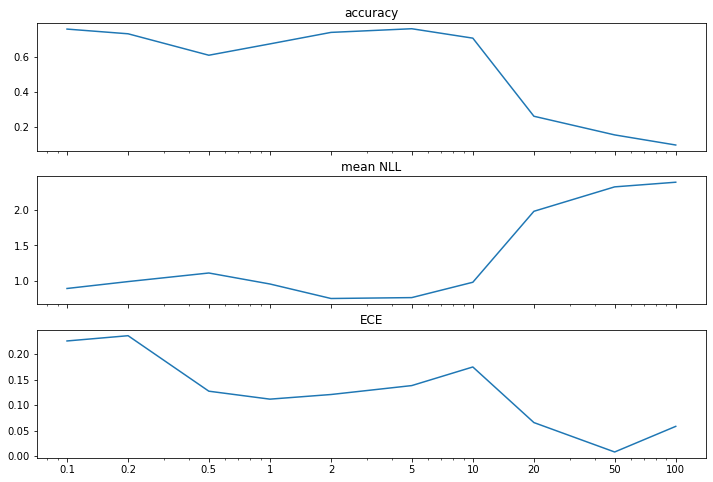

In [20]:
res = classification_models.select_init_lengthscale_with_CV_Dir(X_train, y_train, mode="DGP", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
classification_utils.plot_res(res)
# 5 is best

current lengthscale: 0.1
Iter 1/100 - Loss: 2.891; lengthscale: 0.693; noise: 0.693
Iter 11/100 - Loss: 2.280; lengthscale: 0.364; noise: 1.100
Iter 21/100 - Loss: 2.217; lengthscale: 0.401; noise: 1.058
Iter 31/100 - Loss: 2.182; lengthscale: 0.460; noise: 0.816
Iter 41/100 - Loss: 2.142; lengthscale: 0.403; noise: 0.559
Iter 51/100 - Loss: 2.105; lengthscale: 0.416; noise: 0.341
Iter 61/100 - Loss: 2.075; lengthscale: 0.396; noise: 0.202
Iter 71/100 - Loss: 2.051; lengthscale: 0.398; noise: 0.123
Iter 81/100 - Loss: 2.032; lengthscale: 0.393; noise: 0.079
Iter 91/100 - Loss: 2.015; lengthscale: 0.389; noise: 0.054
acc: 0.9100000262260437;	 mnll:  0.32532206177711487; 	 ece: 0.03821181878447533
current lengthscale: 0.2
Iter 1/100 - Loss: 2.929; lengthscale: 0.693; noise: 0.693
Iter 11/100 - Loss: 2.300; lengthscale: 0.364; noise: 1.145
Iter 21/100 - Loss: 2.231; lengthscale: 0.393; noise: 1.193
Iter 31/100 - Loss: 2.199; lengthscale: 0.473; noise: 0.986
Iter 41/100 - Loss: 2.158; leng

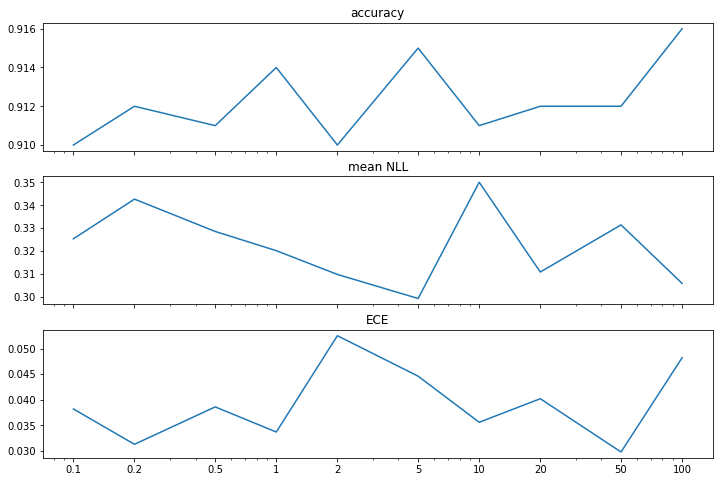

In [21]:
res = classification_models.select_init_lengthscale_with_CV_Dir(X_train, y_train, mode="LMGP_dir", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1, num_classes=NUM_CLASSES,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
classification_utils.plot_res(res)
# 5 is best

In [22]:
res = classification_models.select_init_lengthscale_with_CV_Dir(X_train, y_train, mode="LMGP_dir_con", num_inducing_points=NUM_INDUCING_POINTS, 
                                    learn_noise=True, num_iter=100, lr=0.1, num_classes=NUM_CLASSES,
                                    lengthscales=LENGTHSCALES, max_test_size=1000)

print(res)    
classification_utils.plot_res(res)

NameError: name 'k_means_inducing_points_LM_Dir' is not defined